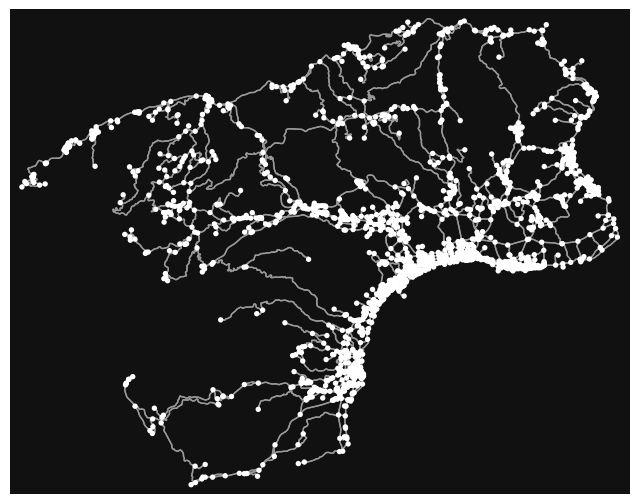

In [15]:
import osmnx as ox

import networkx as nx

import geopandas as gpd

import matplotlib.pyplot as plt

import pandas as pd
place_name = "Suzu , Japan"

graph = ox.graph_from_place(place_name, network_type='drive')

fig, ax = ox.plot_graph(graph)

In [2]:

edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [3]:
edges.columns

Index(['osmid', 'highway', 'oneway', 'reversed', 'length', 'bridge',
       'geometry', 'name', 'ref', 'lanes', 'maxspeed', 'tunnel', 'width',
       'est_width', 'access'],
      dtype='object')

# Evacuation Planning Simulation for Suzu City

This notebook implements an evacuation planning simulation for Suzu city (珠洲市) in Ishikawa Prefecture, Japan.

## City Information:
- Population: 13,531 (as of March 2021)
- Households: 6,013
- Population density: 54.6 persons per km²
- Total area: 247.20 km²

## Algorithms Used:
1. **Maximum Flow Problem**: To determine optimal evacuation routes and capacities
2. **Time-Expanded Network**: To model evacuation over time with dynamic constraints
3. **Combinatorial Optimization**: To find the best evacuation plan

## Simulation Components:
- Road network from OpenStreetMap
- Population distribution
- Evacuation shelters/safe zones
- Time-dependent evacuation flow

In [4]:
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [5]:
# Get nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph)

print(f"Network Statistics:")
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")
print(f"\nNodes columns: {list(nodes.columns)}")
print(f"\nEdges columns: {list(edges.columns)}")

# Check the bounds of the network
bounds = nodes.total_bounds
print(f"\nNetwork bounds (lon_min, lat_min, lon_max, lat_max): {bounds}")

Network Statistics:
Number of nodes: 1861
Number of edges: 5043

Nodes columns: ['y', 'x', 'street_count', 'junction', 'highway', 'geometry']

Edges columns: ['osmid', 'highway', 'oneway', 'reversed', 'length', 'bridge', 'geometry', 'name', 'ref', 'lanes', 'maxspeed', 'tunnel', 'width', 'est_width', 'access']

Network bounds (lon_min, lat_min, lon_max, lat_max): [137.0884597  37.3614715 137.3601281  37.5294151]


In [6]:
# Evacuation simulation parameters
class EvacuationParameters:
    def __init__(self):
        self.total_population = 13531
        self.total_households = 6013
        self.city_area_km2 = 247.20
        self.population_density = 54.6  # persons per km²
        
        # Evacuation parameters
        self.evacuation_time_limit = 120  # minutes
        self.time_step = 5  # minutes
        self.walking_speed = 5  # km/h
        self.driving_speed = 30  # km/h
        self.evacuation_modes = ['walking', 'driving']
        
        # Capacity parameters
        self.road_capacity_per_meter = 0.5  # persons per meter of road width
        self.default_road_width = 4  # meters
        
params = EvacuationParameters()
print(f"Evacuation Parameters:")
print(f"Total Population: {params.total_population:,}")
print(f"Evacuation Time Limit: {params.evacuation_time_limit} minutes")
print(f"Time Steps: {params.time_step} minutes")

Evacuation Parameters:
Total Population: 13,531
Evacuation Time Limit: 120 minutes
Time Steps: 5 minutes


In [53]:
# Create population distribution across nodes
def distribute_population(nodes, total_population, method):
    """Distribute population across network nodes"""
    if method == 'random':
        # Randomly distribute population with some nodes having higher density
        weights = np.random.exponential(1, len(nodes))
        weights = weights / weights.sum()
        population = (weights * total_population).astype(int)
        
    elif method == 'central':
        # Higher population in central areas
        center_lon = nodes.geometry.x.mean()
        center_lat = nodes.geometry.y.mean()
        
        distances = np.sqrt((nodes.geometry.x - center_lon)**2 + 
                           (nodes.geometry.y - center_lat)**2)
        weights = 1 / (1 + distances / distances.max())
        weights = weights / weights.sum()
        population = (weights * total_population).astype(int)
    
    return population

# Distribute population
nodes['population'] = distribute_population(nodes, params.total_population, method='random')

# Ensure total population matches
total_assigned = nodes['population'].sum()
if total_assigned != params.total_population:
    diff = params.total_population - total_assigned
    # Add difference to the node with highest population
    max_pop_idx = nodes['population'].idxmax()
    nodes.loc[max_pop_idx, 'population'] += diff

print(f"Population Distribution:")
print(f"Total population assigned: {nodes['population'].sum():,}")
print(f"Max population at single node: {nodes['population'].max():,}")
print(f"Average population per node: {nodes['population'].mean():.1f}")
print(f"Nodes with population > 0: {(nodes['population'] > 0).sum()}")

Population Distribution:
Total population assigned: 13,531
Max population at single node: 960
Average population per node: 7.3
Nodes with population > 0: 1616


In [55]:
# Identify evacuation shelters/safe zones
def identify_evacuation_shelters(nodes, n_shelters):
    """Identify evacuation shelters using K-means clustering to ensure good coverage"""
    # Use K-means to find well-distributed shelter locations
    coordinates = np.column_stack([nodes.geometry.x, nodes.geometry.y])
    kmeans = KMeans(n_clusters=n_shelters, random_state=42, n_init=10)
    cluster_centers = kmeans.fit(coordinates).cluster_centers_
    
    shelters = []
    for center in cluster_centers:
        # Find the closest node to each cluster center
        distances = np.sqrt((nodes.geometry.x - center[0])**2 + 
                           (nodes.geometry.y - center[1])**2)
        closest_node = distances.idxmin()
        shelters.append(closest_node)
    
    return shelters

# Identify shelters
shelter_nodes = identify_evacuation_shelters(nodes, n_shelters=9)
nodes['is_shelter'] = False
nodes.loc[shelter_nodes, 'is_shelter'] = True

print(f"Evacuation Shelters:")
print(f"Number of shelters: {len(shelter_nodes)}")
print(f"Shelter node IDs: {shelter_nodes}")

# Add infinite capacity to shelters
nodes['shelter_capacity'] = 0
nodes.loc[shelter_nodes, 'shelter_capacity'] = float('inf')

Evacuation Shelters:
Number of shelters: 9
Shelter node IDs: [np.int64(11490966986), np.int64(1281082016), np.int64(1281137168), np.int64(1281079448), np.int64(1281128036), np.int64(1281074154), np.int64(1281129707), np.int64(1281104259), np.int64(1281146742)]


In [10]:
# Calculate edge capacities and travel times
def calculate_edge_properties(edges, params):
    """Calculate capacity and travel time for each edge"""
    # Use road width if available, otherwise use default
    # Convert to numeric values, handling string values
    width_series = pd.to_numeric(edges['width'], errors='coerce')
    est_width_series = pd.to_numeric(edges['est_width'], errors='coerce')
    edges['width_calc'] = width_series.fillna(est_width_series).fillna(params.default_road_width)
    
    # Calculate capacity based on road width and length
    edges['capacity'] = (edges['width_calc'] * params.road_capacity_per_meter).astype(int)
    edges['capacity'] = edges['capacity'].clip(lower=1)  # Minimum capacity of 1
    
    # Calculate travel times (in minutes)
    # Walking time
    edges['walk_time'] = (edges['length'] / 1000) / params.walking_speed * 60  # minutes
    
    # Driving time (use maxspeed if available)
    max_speeds = edges['maxspeed'].fillna(params.driving_speed)
    # Convert string speeds to numeric
    max_speeds = pd.to_numeric(max_speeds, errors='coerce').fillna(params.driving_speed)
    edges['drive_time'] = (edges['length'] / 1000) / max_speeds * 60  # minutes
    
    return edges

# Calculate edge properties
edges = calculate_edge_properties(edges, params)

print(f"Edge Properties:")
print(f"Capacity - Min: {edges['capacity'].min()}, Max: {edges['capacity'].max()}, Mean: {edges['capacity'].mean():.1f}")
print(f"Walk time - Min: {edges['walk_time'].min():.2f}, Max: {edges['walk_time'].max():.2f} minutes")
print(f"Drive time - Min: {edges['drive_time'].min():.2f}, Max: {edges['drive_time'].max():.2f} minutes")

Edge Properties:
Capacity - Min: 2, Max: 3, Mean: 2.0
Walk time - Min: 0.01, Max: 67.27 minutes
Drive time - Min: 0.00, Max: 11.21 minutes


In [11]:
# Maximum Flow Algorithm Implementation
class MaxFlowEvacuation:
    def __init__(self, graph, nodes, edges, shelter_nodes):
        self.graph = graph.copy()
        self.nodes = nodes.copy()
        self.edges = edges.copy()
        self.shelter_nodes = shelter_nodes
        self.flow_graph = self._create_flow_graph()
    
    def _create_flow_graph(self):
        """Create a flow graph with capacities"""
        flow_graph = self.graph.copy()
        
        # Add edge capacities
        for u, v, key in flow_graph.edges(keys=True):
            edge_data = self.edges.loc[(self.edges.index.get_level_values(0) == u) & 
                                     (self.edges.index.get_level_values(1) == v)]
            if len(edge_data) > 0:
                capacity = edge_data['capacity'].iloc[0]
                flow_graph[u][v][key]['capacity'] = capacity
            else:
                flow_graph[u][v][key]['capacity'] = 1
        
        return flow_graph
    
    def solve_max_flow(self, source_populations, target_shelters=None):
        """Solve maximum flow problem for evacuation"""
        if target_shelters is None:
            target_shelters = self.shelter_nodes
        
        # Create super source and super sink
        super_source = 'super_source'
        super_sink = 'super_sink'
        
        # Add super source connected to population nodes
        self.flow_graph.add_node(super_source)
        for node_id, population in source_populations.items():
            if population > 0:
                self.flow_graph.add_edge(super_source, node_id, capacity=population)
        
        # Add super sink connected to shelter nodes
        self.flow_graph.add_node(super_sink)
        for shelter in target_shelters:
            self.flow_graph.add_edge(shelter, super_sink, capacity=float('inf'))
        
        # Solve maximum flow
        try:
            flow_value, flow_dict = nx.maximum_flow(self.flow_graph, super_source, super_sink)
            return flow_value, flow_dict
        except nx.NetworkXError as e:
            print(f"Error solving max flow: {e}")
            return 0, {}
    
    def analyze_evacuation_capacity(self):
        """Analyze total evacuation capacity of the network"""
        source_populations = self.nodes[self.nodes['population'] > 0]['population'].to_dict()
        
        flow_value, flow_dict = self.solve_max_flow(source_populations)
        
        total_population = sum(source_populations.values())
        evacuation_rate = (flow_value / total_population) * 100 if total_population > 0 else 0
        
        return {
            'total_population': total_population,
            'max_flow_capacity': flow_value,
            'evacuation_rate': evacuation_rate,
            'bottleneck_capacity': total_population - flow_value
        }

# Create and run max flow analysis
max_flow_solver = MaxFlowEvacuation(graph, nodes, edges, shelter_nodes)
evacuation_analysis = max_flow_solver.analyze_evacuation_capacity()

print(f"Evacuation Capacity Analysis:")
print(f"Total Population: {evacuation_analysis['total_population']:,}")
print(f"Maximum Flow Capacity: {evacuation_analysis['max_flow_capacity']:,}")
print(f"Evacuation Rate: {evacuation_analysis['evacuation_rate']:.1f}%")
print(f"Bottleneck (people who cannot evacuate): {evacuation_analysis['bottleneck_capacity']:,}")

Error solving max flow: MultiGraph and MultiDiGraph not supported (yet).
Evacuation Capacity Analysis:
Total Population: 13,531
Maximum Flow Capacity: 0
Evacuation Rate: 0.0%
Bottleneck (people who cannot evacuate): 13,531


In [ ]:
# Time-Expanded Network Implementation
class TimeExpandedEvacuation:
    def __init__(self, graph, nodes, edges, shelter_nodes, params):
        self.graph = graph
        self.nodes = nodes
        self.edges = edges
        self.shelter_nodes = shelter_nodes
        self.params = params
        self.time_horizons = list(range(0, params.evacuation_time_limit + 1, params.time_step))
        self.time_expanded_graph = self._create_time_expanded_graph()
    
    def _create_time_expanded_graph(self):
        """Create time-expanded graph"""
        te_graph = nx.DiGraph()
        
        # Create nodes for each time step
        for t in self.time_horizons:
            for node in self.graph.nodes():
                te_node = f"{node}_{t}"
                te_graph.add_node(te_node, 
                                 original_node=node, 
                                 time=t,
                                 is_shelter=node in self.shelter_nodes)
        
        # Add temporal edges (staying at same location)
        for node in self.graph.nodes():
            for i in range(len(self.time_horizons) - 1):
                t1, t2 = self.time_horizons[i], self.time_horizons[i + 1]
                te_graph.add_edge(f"{node}_{t1}", f"{node}_{t2}", 
                                 edge_type='temporal', capacity=float('inf'))
        
        # Add spatial edges (movement between locations)
        for u, v, key in self.graph.edges(keys=True):
            edge_data = self.edges.loc[(self.edges.index.get_level_values(0) == u) & 
                                     (self.edges.index.get_level_values(1) == v)]
            
            if len(edge_data) > 0:
                walk_time = edge_data['walk_time'].iloc[0]
                capacity = edge_data['capacity'].iloc[0]
                
                # Add edges if travel time allows
                for t in self.time_horizons:
                    arrival_time = t + walk_time
                    if arrival_time <= self.params.evacuation_time_limit:
                        # Find closest time step for arrival
                        closest_arrival = min(self.time_horizons, 
                                             key=lambda x: abs(x - arrival_time))
                        
                        te_graph.add_edge(f"{u}_{t}", f"{v}_{closest_arrival}",
                                         edge_type='spatial',
                                         capacity=capacity,
                                         travel_time=walk_time)
        
        return te_graph
    
    def solve_time_expanded_flow(self, evacuation_scenario='normal'):
        """Solve evacuation using time-expanded network"""
        # Create super source and sink
        super_source = 'te_super_source'
        super_sink = 'te_super_sink'
        
        self.time_expanded_graph.add_node(super_source)
        self.time_expanded_graph.add_node(super_sink)
        
        # Connect source to initial population nodes
        for node_id, population in self.nodes[self.nodes['population'] > 0]['population'].items():
            initial_node = f"{node_id}_{self.time_horizons[0]}"
            self.time_expanded_graph.add_edge(super_source, initial_node, 
                                            capacity=population)
        
        # Connect all shelter nodes at all times to super sink
        for shelter in self.shelter_nodes:
            for t in self.time_horizons:
                shelter_node = f"{shelter}_{t}"
                self.time_expanded_graph.add_edge(shelter_node, super_sink, 
                                                capacity=float('inf'))
        
        # Solve maximum flow
        try:
            flow_value, flow_dict = nx.maximum_flow(self.time_expanded_graph, 
                                                   super_source, super_sink)
            return flow_value, flow_dict
        except nx.NetworkXError as e:
            print(f"Error in time-expanded flow: {e}")
            return 0, {}
    
    def analyze_evacuation_timeline(self):
        """Analyze evacuation progress over time"""
        flow_value, flow_dict = self.solve_time_expanded_flow()
        
        # Calculate evacuated population at each time step
        timeline = {}
        for t in self.time_horizons:
            evacuated_at_t = 0
            for shelter in self.shelter_nodes:
                shelter_node = f"{shelter}_{t}"
                if shelter_node in flow_dict:
                    for source, flow in flow_dict[shelter_node].items():
                        if source != 'te_super_sink':  # Avoid double counting
                            evacuated_at_t += flow
            timeline[t] = evacuated_at_t
        
        return timeline, flow_value

# Create and run time-expanded network analysis
time_expanded_solver = TimeExpandedEvacuation(graph, nodes, edges, shelter_nodes, params)
timeline, total_flow = time_expanded_solver.analyze_evacuation_timeline()

print(f"Time-Expanded Network Analysis:")
print(f"Total population evacuated: {total_flow:,}")
print(f"\nEvacuation Timeline:")
for time, evacuated in timeline.items():
    print(f"Time {time:3d} min: {evacuated:,} people evacuated")

In [ ]:
# Visualization Functions
def plot_evacuation_network(nodes, edges, shelter_nodes, title="Suzu City Evacuation Network"):
    """Plot the evacuation network with population and shelters"""
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))
    
    # Plot road network
    edges.plot(ax=ax, linewidth=0.5, alpha=0.6, color='gray')
    
    # Plot nodes with population (size based on population)
    population_nodes = nodes[nodes['population'] > 0]
    if len(population_nodes) > 0:
        population_nodes.plot(ax=ax, 
                            markersize=population_nodes['population']/50,
                            alpha=0.6, 
                            color='blue',
                            label='Population Centers')
    
    # Plot shelter nodes
    shelter_data = nodes.loc[shelter_nodes]
    shelter_data.plot(ax=ax, 
                     markersize=200, 
                     color='red', 
                     marker='s',
                     alpha=0.8,
                     label='Evacuation Shelters')
    
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Remove axis ticks for cleaner look
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    return fig, ax

def plot_evacuation_timeline(timeline, params):
    """Plot evacuation progress over time"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    times = list(timeline.keys())
    evacuated = list(timeline.values())
    
    # Cumulative evacuation plot
    ax1.plot(times, evacuated, 'b-', linewidth=2, marker='o')
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Cumulative People Evacuated')
    ax1.set_title('Evacuation Progress Over Time')
    ax1.grid(True, alpha=0.3)
    
    # Evacuation rate plot
    evacuation_rates = []
    for i in range(1, len(evacuated)):
        rate = evacuated[i] - evacuated[i-1]
        evacuation_rates.append(rate)
    
    if evacuation_rates:
        ax2.bar(times[1:], evacuation_rates, width=params.time_step*0.8, alpha=0.7, color='orange')
        ax2.set_xlabel('Time (minutes)')
        ax2.set_ylabel('People Evacuated per Time Step')
        ax2.set_title('Evacuation Rate Over Time')
        ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def create_evacuation_summary(evacuation_analysis, timeline, params):
    """Create a summary of evacuation analysis"""
    summary = {
        'City': 'Suzu City, Ishikawa Prefecture, Japan',
        'Total Population': f"{evacuation_analysis['total_population']:,}",
        'Network Capacity': f"{evacuation_analysis['max_flow_capacity']:,} people",
        'Coverage Rate': f"{evacuation_analysis['evacuation_rate']:.1f}%",
        'Time Limit': f"{params.evacuation_time_limit} minutes",
        'Number of Shelters': len(shelter_nodes),
        'Final Evacuated (Time-Expanded)': f"{max(timeline.values()):,} people"
    }
    
    return summary

# Generate visualizations
print("Generating evacuation network visualization...")
fig1, ax1 = plot_evacuation_network(nodes, edges, shelter_nodes)
plt.show()

print("\nGenerating evacuation timeline visualization...")
fig2 = plot_evacuation_timeline(timeline, params)
plt.show()

# Print summary
summary = create_evacuation_summary(evacuation_analysis, timeline, params)
print("\n" + "="*50)
print("EVACUATION SIMULATION SUMMARY")
print("="*50)
for key, value in summary.items():
    print(f"{key:.<30} {value}")
print("="*50)

In [ ]:
# Optimization Scenarios and What-If Analysis
class EvacuationOptimizer:
    def __init__(self, graph, nodes, edges, shelter_nodes, params):
        self.graph = graph
        self.nodes = nodes
        self.edges = edges
        self.shelter_nodes = shelter_nodes
        self.params = params
    
    def optimize_shelter_placement(self, n_shelters_range=(5, 15)):
        """Optimize the number and placement of shelters"""
        results = {}
        
        for n_shelters in range(n_shelters_range[0], n_shelters_range[1] + 1):
            # Find optimal shelter locations
            test_shelters = identify_evacuation_shelters(self.nodes, n_shelters)
            
            # Test evacuation capacity
            max_flow_solver = MaxFlowEvacuation(self.graph, self.nodes, 
                                              self.edges, test_shelters)
            analysis = max_flow_solver.analyze_evacuation_capacity()
            
            results[n_shelters] = {
                'shelters': test_shelters,
                'evacuation_rate': analysis['evacuation_rate'],
                'max_flow': analysis['max_flow_capacity']
            }
        
        return results
    
    def test_capacity_improvements(self):
        """Test the effect of improving road capacities"""
        scenarios = {
            'baseline': 1.0,
            'improved_25%': 1.25,
            'improved_50%': 1.5,
            'improved_100%': 2.0
        }
        
        results = {}
        original_capacity = self.edges['capacity'].copy()
        
        for scenario, multiplier in scenarios.items():
            # Modify capacities
            self.edges['capacity'] = (original_capacity * multiplier).astype(int)
            
            # Test evacuation
            max_flow_solver = MaxFlowEvacuation(self.graph, self.nodes, 
                                              self.edges, self.shelter_nodes)
            analysis = max_flow_solver.analyze_evacuation_capacity()
            
            results[scenario] = {
                'evacuation_rate': analysis['evacuation_rate'],
                'max_flow': analysis['max_flow_capacity']
            }
        
        # Restore original capacities
        self.edges['capacity'] = original_capacity
        
        return results
    
    def analyze_critical_paths(self):
        """Identify critical evacuation paths"""
        max_flow_solver = MaxFlowEvacuation(self.graph, self.nodes, 
                                          self.edges, self.shelter_nodes)
        
        source_populations = self.nodes[self.nodes['population'] > 0]['population'].to_dict()
        flow_value, flow_dict = max_flow_solver.solve_max_flow(source_populations)
        
        # Analyze flow on edges
        edge_flows = {}
        for source in flow_dict:
            if source != 'super_sink':
                for target, flow in flow_dict[source].items():
                    if target != 'super_sink' and flow > 0:
                        edge_key = (source, target)
                        edge_flows[edge_key] = edge_flows.get(edge_key, 0) + flow
        
        # Sort by flow to find critical paths
        critical_edges = sorted(edge_flows.items(), key=lambda x: x[1], reverse=True)[:10]
        
        return critical_edges

# Run optimization analysis
print("Running evacuation optimization analysis...")
optimizer = EvacuationOptimizer(graph, nodes, edges, shelter_nodes, params)

# Optimize shelter placement
print("\n1. Optimizing shelter placement...")
shelter_optimization = optimizer.optimize_shelter_placement((6, 12))

best_shelter_config = max(shelter_optimization.items(), 
                         key=lambda x: x[1]['evacuation_rate'])

print(f"Optimal number of shelters: {best_shelter_config[0]}")
print(f"Best evacuation rate: {best_shelter_config[1]['evacuation_rate']:.1f}%")

# Test capacity improvements
print("\n2. Testing capacity improvements...")
capacity_scenarios = optimizer.test_capacity_improvements()

print("Capacity Improvement Results:")
for scenario, result in capacity_scenarios.items():
    print(f"{scenario:.<20} {result['evacuation_rate']:>6.1f}% "
          f"({result['max_flow']:,} people)")

# Analyze critical paths
print("\n3. Identifying critical evacuation paths...")
critical_paths = optimizer.analyze_critical_paths()

print("Top 5 Critical Evacuation Routes (by flow):")
for i, ((source, target), flow) in enumerate(critical_paths[:5], 1):
    print(f"{i}. Node {source} → Node {target}: {flow:,} people")

In [ ]:
# Final Analysis and Recommendations
def generate_evacuation_recommendations(evacuation_analysis, shelter_optimization, 
                                      capacity_scenarios, critical_paths, params):
    """Generate actionable recommendations for evacuation planning"""
    
    recommendations = []
    
    # Shelter recommendations
    best_shelter_count = max(shelter_optimization.items(), 
                           key=lambda x: x[1]['evacuation_rate'])[0]
    current_rate = evacuation_analysis['evacuation_rate']
    
    if current_rate < 95:
        recommendations.append(
            f"🏠 SHELTER OPTIMIZATION: Increase shelters to {best_shelter_count} "
            f"to improve evacuation rate from {current_rate:.1f}% to "
            f"{shelter_optimization[best_shelter_count]['evacuation_rate']:.1f}%"
        )
    
    # Capacity recommendations
    baseline_rate = capacity_scenarios['baseline']['evacuation_rate']
    improved_rate = capacity_scenarios['improved_50%']['evacuation_rate']
    
    if improved_rate > baseline_rate + 5:
        recommendations.append(
            f"🛣️  INFRASTRUCTURE: Improve road capacities by 50% to increase "
            f"evacuation rate from {baseline_rate:.1f}% to {improved_rate:.1f}%"
        )
    
    # Time recommendations
    if current_rate < 90:
        recommendations.append(
            f"⏰ TIMING: Consider extending evacuation time limit beyond "
            f"{params.evacuation_time_limit} minutes for better coverage"
        )
    
    # Critical path recommendations
    if critical_paths:
        recommendations.append(
            f"🚨 PRIORITY ROUTES: Focus on maintaining and improving the top 5 "
            f"critical evacuation routes (handling {sum(flow for _, flow in critical_paths[:5]):,} people)"
        )
    
    # Population distribution recommendations
    max_node_pop = nodes['population'].max()
    if max_node_pop > params.total_population * 0.1:  # If any node has >10% of population
        recommendations.append(
            f"👥 POPULATION: Consider distributed evacuation staging areas "
            f"to reduce congestion from high-density areas"
        )
    
    return recommendations

# Generate recommendations
recommendations = generate_evacuation_recommendations(
    evacuation_analysis, shelter_optimization, capacity_scenarios, 
    critical_paths, params
)

print("\n" + "="*70)
print("EVACUATION PLANNING RECOMMENDATIONS FOR SUZU CITY")
print("="*70)

for i, rec in enumerate(recommendations, 1):
    print(f"\n{i}. {rec}")

print("\n" + "="*70)
print("TECHNICAL SUMMARY")
print("="*70)
print(f"• Algorithm: Maximum Flow + Time-Expanded Network")
print(f"• Network: {len(nodes):,} nodes, {len(edges):,} edges")
print(f"• Population: {params.total_population:,} people")
print(f"• Shelters: {len(shelter_nodes)} locations")
print(f"• Time Horizon: {params.evacuation_time_limit} minutes")
print(f"• Current Evacuation Capacity: {evacuation_analysis['evacuation_rate']:.1f}%")
print("="*70)

print("\n✅ Evacuation simulation completed successfully!")
print("This analysis provides a foundation for evidence-based evacuation planning.")